In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer


                                               name neighbourhood_group  \
0                Clean & quiet apt home by the park            Brooklyn   
1                             Skylit Midtown Castle           Manhattan   
2               THE VILLAGE OF HARLEM....NEW YORK !           Manhattan   
3                   Cozy Entire Floor of Brownstone            Brooklyn   
4  Entire Apt: Spacious Studio/Loft by central park           Manhattan   

  neighbourhood  latitude  longitude        room_type  price  minimum_nights  \
0    Kensington  40.64749  -73.97237     Private room    149               1   
1       Midtown  40.75362  -73.98377  Entire home/apt    225               1   
2        Harlem  40.80902  -73.94190     Private room    150               3   
3  Clinton Hill  40.68514  -73.95976  Entire home/apt     89               1   
4   East Harlem  40.79851  -73.94399  Entire home/apt     80              10   

   number_of_reviews last_review  reviews_per_month  \
0            

In [ ]:


# Cargar el archivo CSV
df = pd.read_csv('AB_NYC_2019.csv')


df = df.drop(['id', 'host_id', 'host_name'], axis=1)

df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['year'] = df['last_review'].dt.year
df['month'] = df['last_review'].dt.month
df['day'] = df['last_review'].dt.day


df['number_of_reviews'] = df['number_of_reviews'].fillna(0)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

df['last_review'] = df['last_review'].fillna(pd.Timestamp("2019-01-01"))


print(df.head())


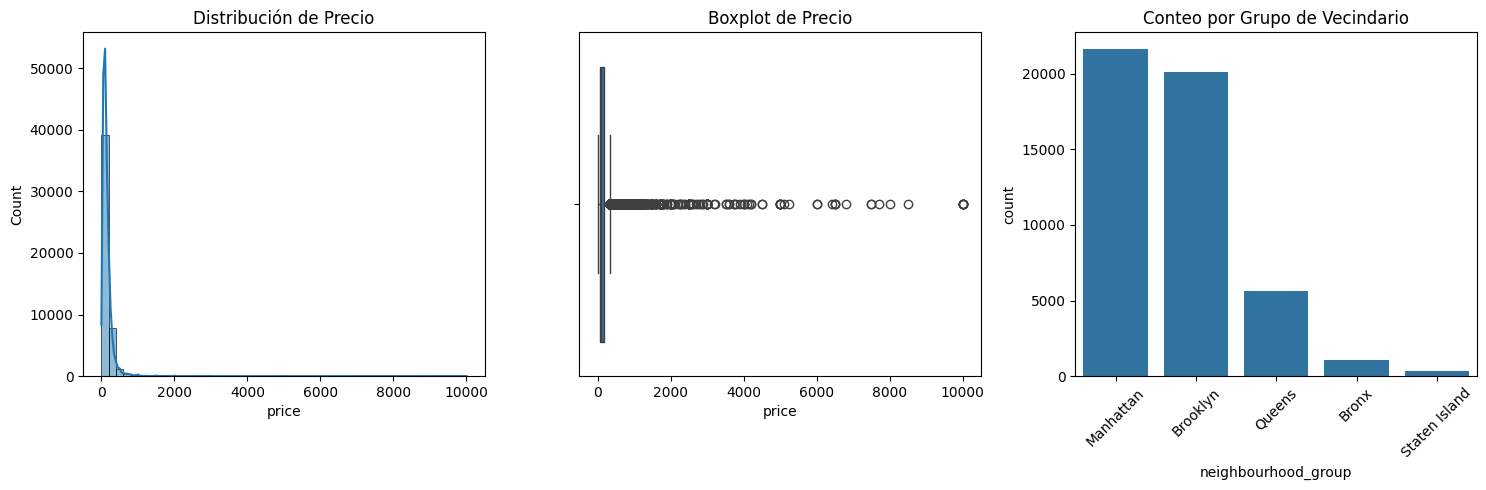

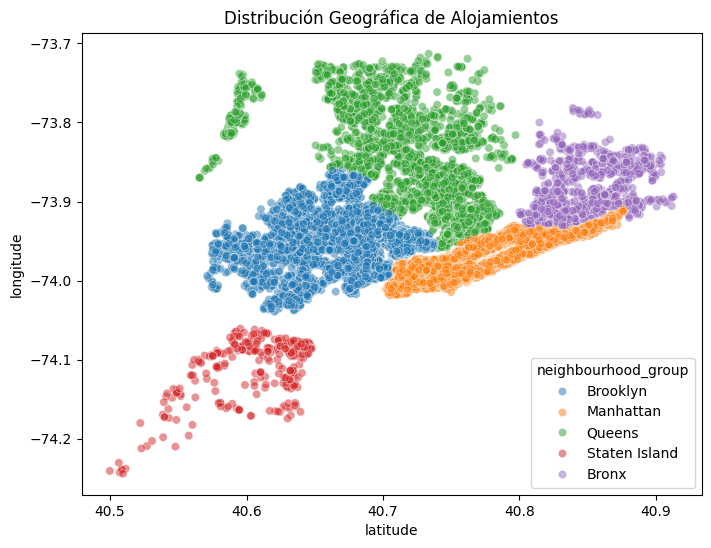

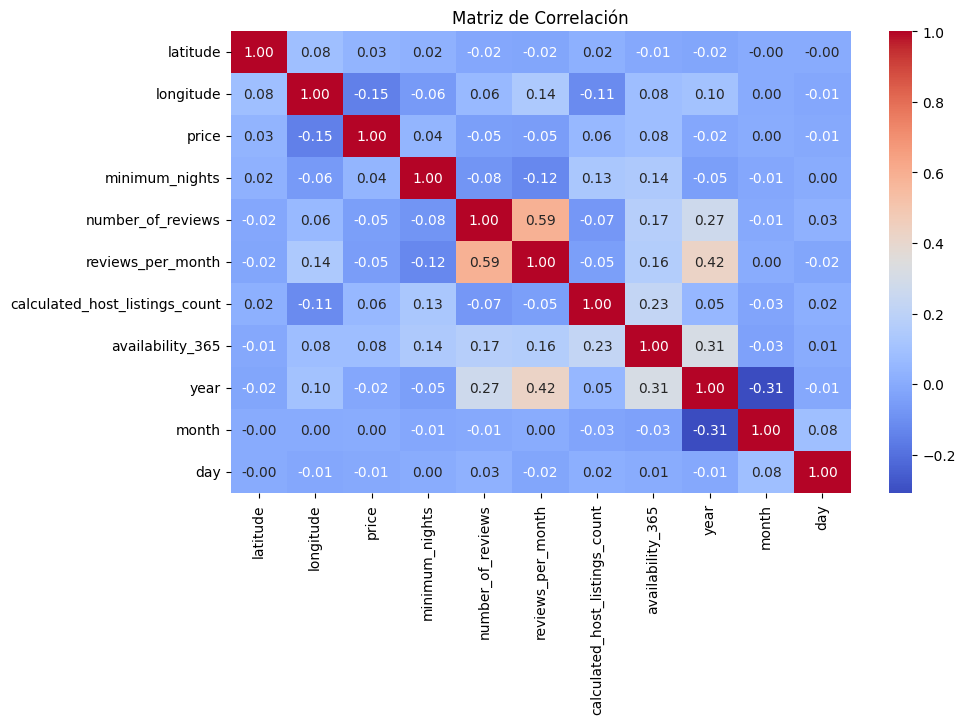

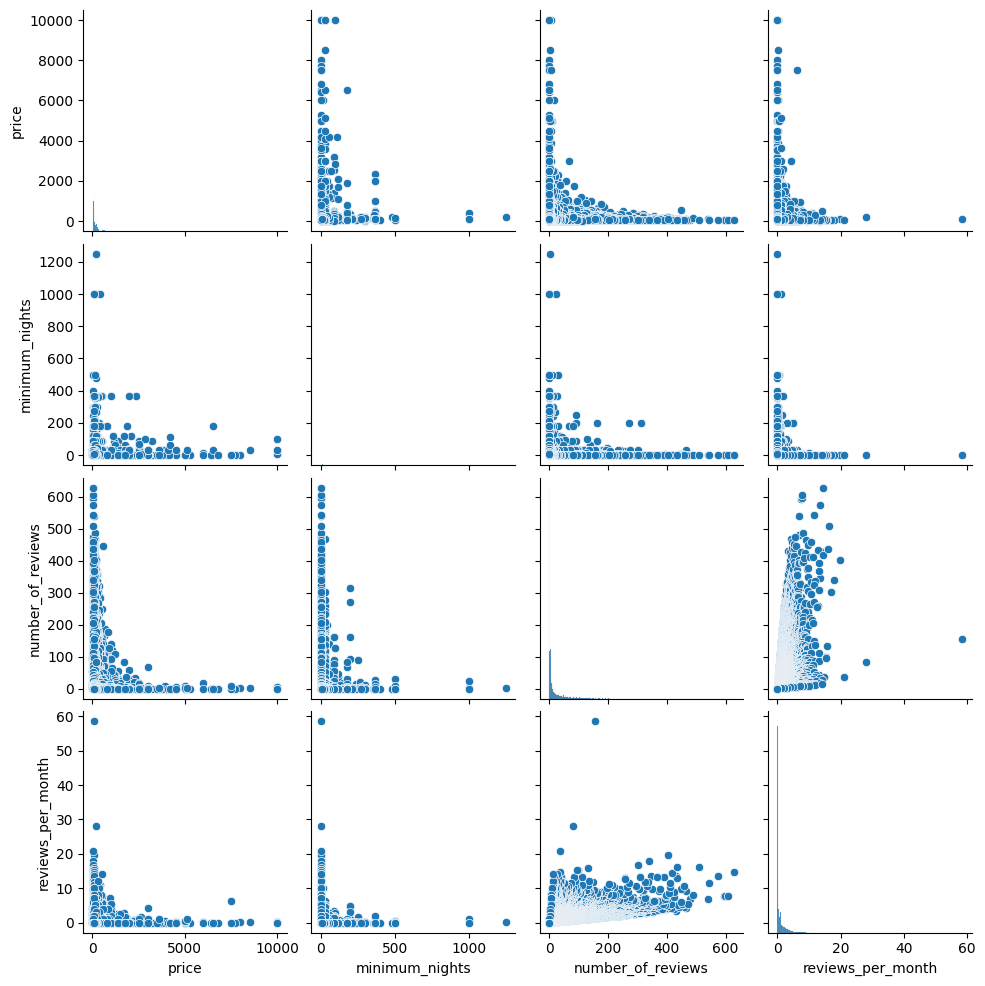

In [2]:
# EDA Univariante
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribución de Precio")

plt.subplot(1, 3, 2)
sns.boxplot(x=df["price"])
plt.title("Boxplot de Precio")

plt.subplot(1, 3, 3)
sns.countplot(x=df["neighbourhood_group"], order=df["neighbourhood_group"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Conteo por Grupo de Vecindario")

plt.tight_layout()
plt.show()

# EDA Bivariante
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["latitude"], y=df["longitude"], hue=df["neighbourhood_group"], alpha=0.5)
plt.title("Distribución Geográfica de Alojamientos")
plt.show()

# EDA Multivariante: Correlación y Pairplot
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include="number").corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

sns.pairplot(df[["price", "minimum_nights", "number_of_reviews", "reviews_per_month"]])
plt.show()

In [4]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop('price', axis=1)
y = df['price']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar las columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocesamiento para columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocesamiento para columnas categóricas (con OrdinalEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Preprocesamiento para columnas con valores ordinales (solo un ejemplo con 'room_type')
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[['Private room', 'Entire home/apt', 'Shared room']]))
])

# Combinar todos los preprocesadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ordinal', ordinal_transformer, ['room_type'])
    ]
)

# Función para eliminar columnas con varianza cero
def remove_zero_variance(X):
    X_dense = X if isinstance(X, np.ndarray) else X.toarray()
    var = np.var(X_dense, axis=0)
    return X_dense[:, var > 0]

# Pipeline completo con reducción de características y PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('remove_zero_variance', FunctionTransformer(remove_zero_variance, validate=False)),
    ('pca', PCA(n_components=10)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10))
])

# Aplicar preprocesado a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train, y_train)

# Aplicar preprocesado a los datos de prueba
X_test_transformed = pipeline.transform(X_test)

# Crear modelos de regresión
models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Evaluar los modelos
for model_name, model in models.items():
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    
    # Evaluación de los resultados
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = accuracy_score(np.round(y_test), np.round(y_pred))  
    
    print(f"Evaluating {model_name}...")
    print(f"Error cuadrático medio (MSE): {mse}")
    print(f"R^2: {r2}")
    print(f"Accuracy: {accuracy}")
    print("-" * 50)


Evaluating Random Forest...
Error cuadrático medio (MSE): 86699.60087538604
R^2: -0.9598339573251122
Accuracy: 0.002863278453829635
--------------------------------------------------
Evaluating Gradient Boosting...
Error cuadrático medio (MSE): 70360.05653029216
R^2: -0.5904805401074125
Accuracy: 0.0044994375703037125
--------------------------------------------------


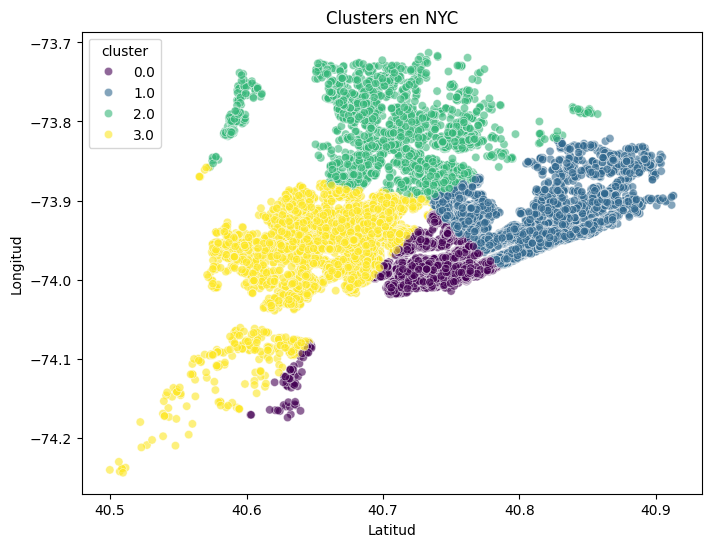

In [8]:

from sklearn.cluster import KMeans


# Seleccionar solo dos variables para clustering
X = df[["latitude", "longitude"]].dropna()  

# Aplicar K-Means con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df.loc[X.index, "cluster"] = kmeans.fit_predict(X)

# Scatterplot con clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["latitude"], y=df["longitude"], hue=df["cluster"], palette="viridis", alpha=0.6)
plt.title("Clusters en NYC")
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.show()


Mejores características seleccionadas para regresión: Index(['longitude', 'minimum_nights', 'number_of_reviews'], dtype='object')
Varianza explicada por cada componente de PCA: [0.960054   0.03301088]


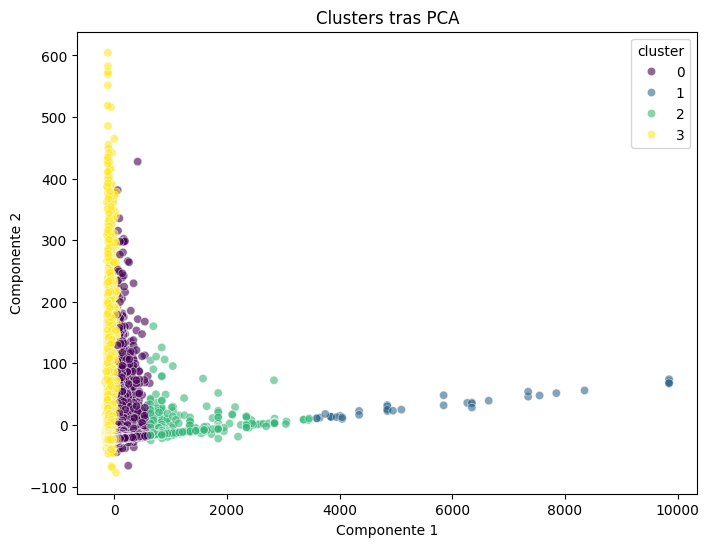

In [9]:


# Definir X (características) y y (objetivo)
X = df[["latitude", "longitude", "price", "minimum_nights", "number_of_reviews"]].dropna()
y = df["availability_365"]  # Suponiendo que quieres predecir 'availability_365'

# Selección de las mejores características para regresión
selector = SelectKBest(score_func=f_regression, k=3)
X_new = selector.fit_transform(X, y)

# Mostrar las mejores características
selected_columns = X.columns[selector.get_support()]
print(f"Mejores características seleccionadas para regresión: {selected_columns}")


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Aplicar PCA para reducir la dimensionalidad (a 2 componentes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualización de la varianza explicada por PCA
print(f"Varianza explicada por cada componente de PCA: {pca.explained_variance_ratio_}")

# Aplicar KMeans para clasificación
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_pca)

# Visualizar los resultados con scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["cluster"], palette="viridis", alpha=0.6)
plt.title("Clusters tras PCA")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


In [10]:


# Definir X (características) y y (objetivo)
X = df[["latitude", "longitude", "minimum_nights", "number_of_reviews", "availability_365"]].dropna()
y = df["price"].dropna()

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print(f"Error cuadrático medio (MSE): {mse:.4f}")
print(f"R^2: {r2:.4f}")


Error cuadrático medio (MSE): 42552.6982
R^2: 0.0381


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir X (características) y y (objetivo)
X = df[["latitude", "longitude", "minimum_nights", "number_of_reviews", "availability_365"]].dropna()
y = df["room_type"].dropna()

# Codificar la variable categórica 'room_type'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de clasificación
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)

# Mostrar los resultados
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6717


In [12]:


X = df[["latitude", "longitude", "minimum_nights", "number_of_reviews", "availability_365"]].dropna()
y = df["room_type"].dropna()

# Codificar la variable 'room_type'
y_encoded = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Modelo y predicciones
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Accuracy: 0.6717


Evaluating RandomForest...
Evaluating GradientBoosting...
Evaluating KNeighbors...
              Model  Accuracy  Std Accuracy  Time Fit
0      RandomForest  0.549161      0.004032  0.549161
1  GradientBoosting  0.583265      0.003467  0.583265
2        KNeighbors  0.552971      0.002392  0.552971


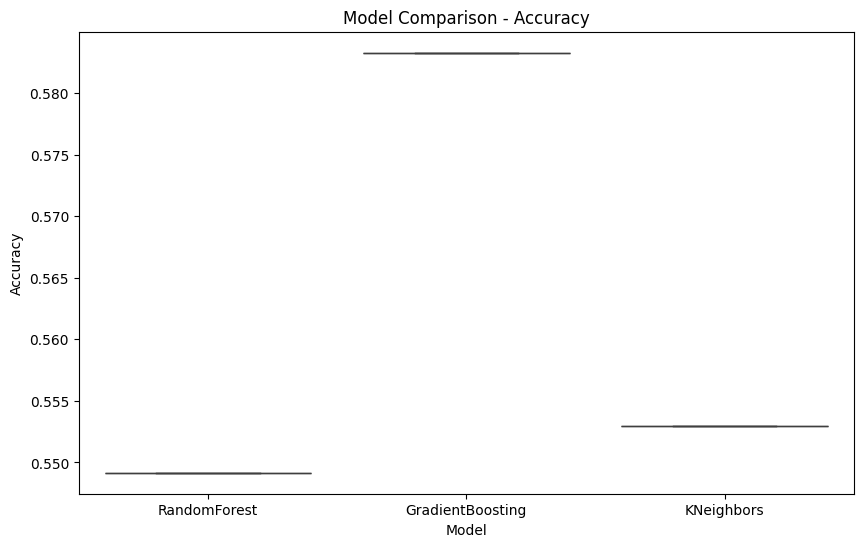

In [13]:

# Seleccionar características y eliminar los valores nulos
X = df[["latitude", "longitude", "minimum_nights", "number_of_reviews", "availability_365"]].dropna()
y = df["room_type"].dropna()

# Codificar la variable categórica 'room_type'
y_encoded = LabelEncoder().fit_transform(y)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Escalado de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Inicializar los modelos
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier()
}

# Lista para guardar los resultados
results = []

# Realizar validación cruzada
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    cross_val = cross_val_score(model, X_train_pca, y_train, cv=StratifiedKFold(5), scoring='accuracy')
    
    # Métricas
    accuracy = cross_val.mean()
    std_accuracy = cross_val.std()
    time_fit = np.mean(cross_val) 
    
    # Guardar los resultados
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Std Accuracy': std_accuracy,
        'Time Fit': time_fit
    })

df_results = pd.DataFrame(results)


print(df_results)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Accuracy', data=df_results)
plt.title('Model Comparison - Accuracy')
plt.show()
